# UKMO Nimrod gridded data files tutorial - Work in progress

This notebook introduces gridded radar data from 

The notebook will explore:
1. Opening the file(s) into an xarray dataset via Iris
2. Plotting the precipitation estimates spatially
3. Extracting timeseries of precipitation intensity at specified point locations

To achieve that we'll import and use the following python packages:

In [1]:
import xarray
import iris
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy
import cartopy.crs as ccrs
from pyproj import Transformer
from pyproj import CRS

import tarfile
import gzip
import shutil
import pathlib

## 1. Accessing and opening the data files

The Nimrod data files can be easily read using the python package [Iris]().

After reading them we'll convert to xarray for easier manipulation and plotting [xarray](https://docs.xarray.dev/en/stable/). Iris may also have some of these functions, so if you are familiar with Iris you could continue to use that instead.

The data files are stored on the CEDA archive (accessible from within Jasmin, provided you have applied for the correct permissions, see instructions) in daily tar files - first we'll have to extract some files to a temporary location.

In [2]:
# data_folder = '/gws/smf/j07/ncas_radar/EA_integration/data/UKMO/20181101/'
# data_files = os.listdir(data_folder) # Use os to list all files in the directory
# data_files.sort() # Sort the list, making use of the naming structure of the files to create a time ordered list

# Use a list comprehension to go from file names to full paths
# data_files = [os.path.join(data_folder,data_file) for data_file in data_files if 'nimrod' in data_file]
# data_files = [data_file for data_file in data_files if 'rainrate' in data_file]

In [3]:
badc_folder = '/badc/ukmo-nimrod/data/composite/uk-1km/2018/'
target_date = '20181101'

gz_files = [os.path.join(badc_folder, gz_file) for gz_file in os.listdir(badc_folder) if target_date in gz_file]

tmp_folder = os.path.join(pathlib.Path.home(),'temp_files/ukmo_nimrod')

if not os.path.isdir(tmp_folder):
    os.makedirs(tmp_folder)

with tarfile.open(gz_files[0]) as opentar:
    opentar.extractall(tmp_folder)

for tmp_gz_file in [os.path.join(tmp_folder,tmp_file) for tmp_file in os.listdir(tmp_folder) if '.gz' in tmp_file]:
    with gzip.open(tmp_gz_file, 'rb') as f_in:
        with open(tmp_gz_file[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            

data_files = [os.path.join(tmp_folder,data_file) for data_file in os.listdir(tmp_folder) if data_file[-3:] == 'dat']
data_files.sort() # Sort the list, making use of the naming structure of the files to create a time ordered list


Now we can use xarray to read all those files (or a subset thereof) into an xarray dataset object. Here we'll use a subset of the files to reduce read time, but reading an entire day is easily possible, so feel free to experiment.

In [4]:
len(data_files)

288

In [5]:
UKMO_iris = iris.load(data_files[:25])

Now we can explore the dataset object and the data fields within:

In [6]:
UKMO_iris

[<iris 'Cube' of Rainfall rate Composite / (mm/h) (time: 25; projection_y_coordinate: 2175; projection_x_coordinate: 1725)>]

In [7]:
y = UKMO_iris[0].coord('projection_y_coordinate')
x = UKMO_iris[0].coord('projection_x_coordinate')
t = UKMO_iris[0].coord('time')

In [8]:
transformer_to_latlon = Transformer.from_proj(x.coord_system.as_cartopy_crs(), "EPSG:4326")
ygrid, xgrid = np.meshgrid(y.points, x.points)
latgrid, longrid = transformer_to_latlon.transform(xgrid,ygrid)

In [9]:
ukmo_dataset = xarray.Dataset({'rainrate': xarray.DataArray(data=UKMO_iris[0].data,
                 coords={'Time': pd.to_datetime(t.points,unit='s'),
                         'y': y.points,
                         'x': x.points,
                         'lon': (['x','y'], longrid),
                         'lat': (['x','y'], latgrid)},
                              dims=('Time','y','x'))})

In [10]:
ukmo_dataset['rainrate']

<xarray.DataArray 'rainrate' (Time: 25, y: 2175, x: 1725)> Size: 375MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 200B 2018-11-01 ... 2018-11-01T02:00:00
  * y        (y) float32 9kB -6.245e+05 -6.235e+05 ... 1.548e+06 1.55e+06
  * x        (x) float32 7kB -4.045e+05 -4.035e+05 ... 1.318e+06 1.32e+06
    lon      (x, y) float64 30MB -12.01 -12.01 -12.01 ... 16.11 16.11 16.12
    lat      (x, y) float64 30MB 43.84 43.85 43.86 43.87 ... 62.63 62.64 62.65

In [11]:
ukmo_dataset['rainrate'].values = np.where(ukmo_dataset['rainrate'].values==-1,
                                                    np.nan,
                                                    ukmo_dataset['rainrate'].values)
## Previous versions of Iris read the data natively from Nimrod, where it is stored as rainrate*32. Using v3.10.0 as found in Jaspy the Iris reader now converts the data when it is read from file.
## Similarly time in the native file is in hours past the datum, but Iris now converts that to seconds past the datum. Older versions of Iris may not behave the same.
#ukmo_dataset['rainrate'].values = ukmo_dataset['rainrate'].values/32.0 

## 2. Plotting simple visualisations

We can now use xarray's inbuilt plot routines. They add axes labels and colorbar labels which wouldn't be added by just using matplotlib, allowing a quicker look at what the data structure actually is. First we'll show a single timestep of the data and then a timeseries for a single location. Xarray also allows fancier indexing and selection using actual dimensions, which we will look at later.

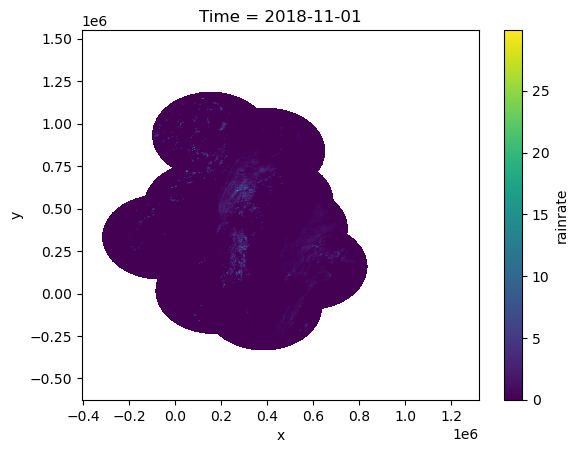

In [12]:
ukmo_dataset['rainrate'][0].plot() # 'Time' is the first dimension, so we can use array style indexing to select the first timestep.

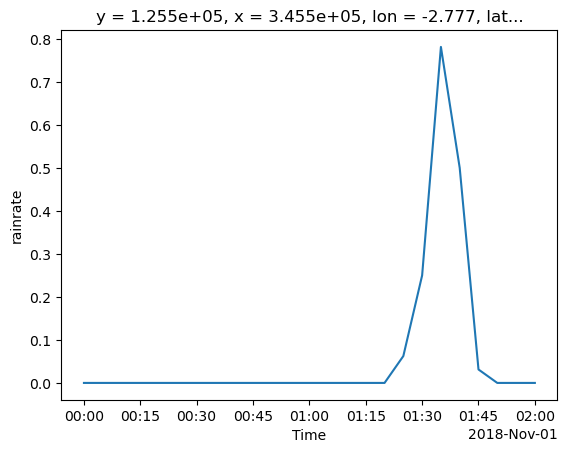

In [13]:
ukmo_dataset['rainrate'][:,750,750].plot() # Take all 'Time' (first index) for the grid box at x,y index location 150,150.

While the 2D view provides geographic axes it is often easier to locate data through reference to coastlines (especially in the British Isles). In order to plot coastlines we'll use the Cartopy package and define a projection to match that of the OS British National Grid. We can then add a coastline to the xarray plot.

In [14]:
cart_osgb = cartopy.crs.TransverseMercator(central_longitude=-2.0,
                                           central_latitude=49.0,
                                           false_easting=400000,
                                           false_northing=-100000,
                                           scale_factor=0.9996012717)

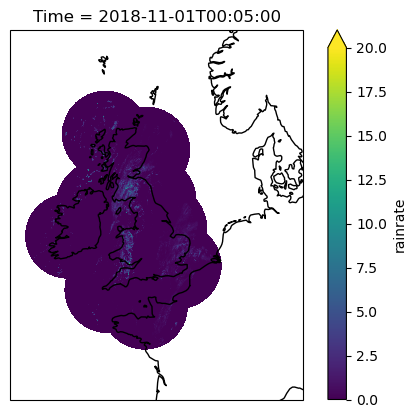

In [15]:
ax = plt.subplot(111, projection=cart_osgb)
ukmo_dataset['rainrate'][1].plot.imshow(vmin=0,vmax=20)
ax.coastlines()

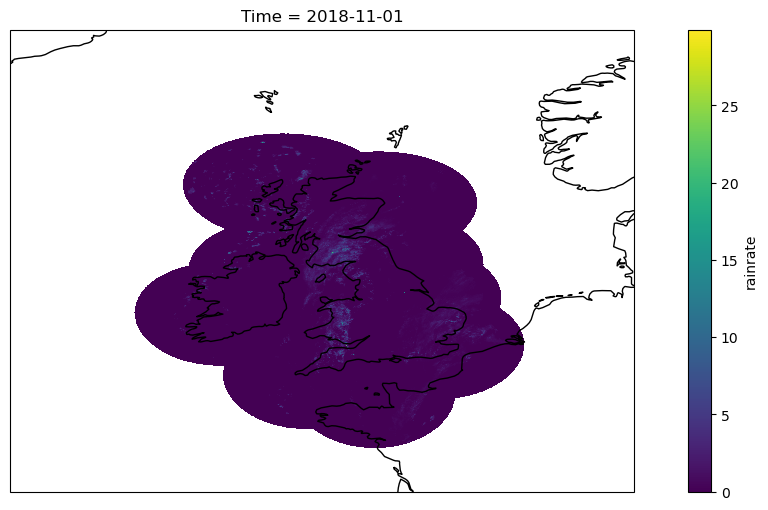

In [16]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ukmo_dataset.rainrate[0].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", add_colorbar=True
)
ax.coastlines()
ax.set_ylim([45, 65])
ax.set_xlim([-18,9]);

To gain more flexibility in plotting we can step back to using matplotlib. In this case we'll use that flexibility to mask out very low / zero values of precipitation intensity, making it clearer where precipitation is falling within the radar domain. We'll then add matplotlib labels and titles to match the xarray plot as closely as possible. By using a loop we can generate multiple plots, in this example one for every fifth timestep.

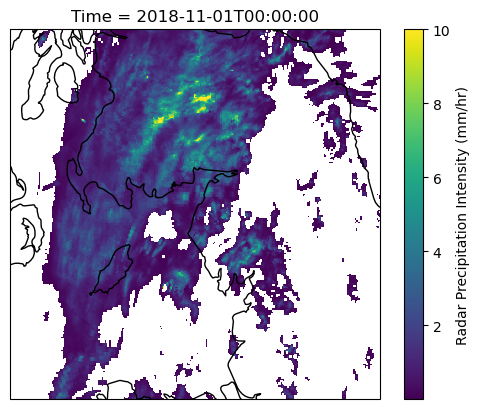

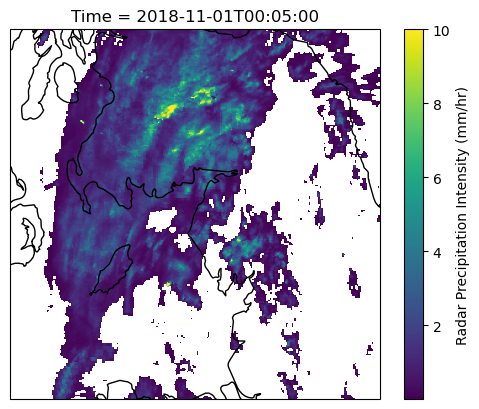

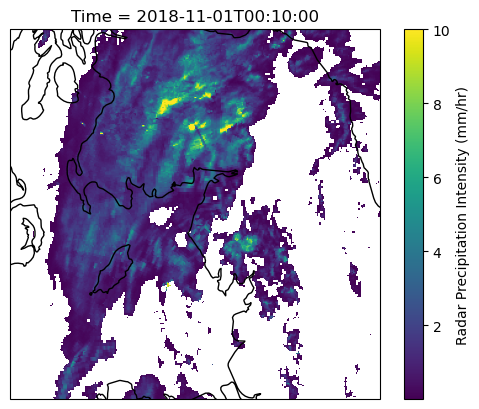

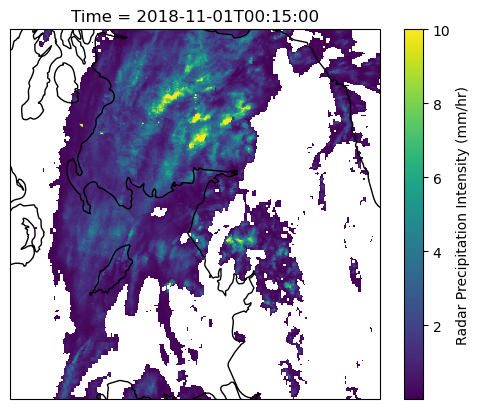

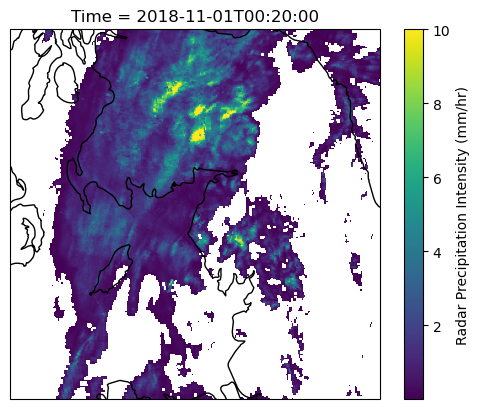

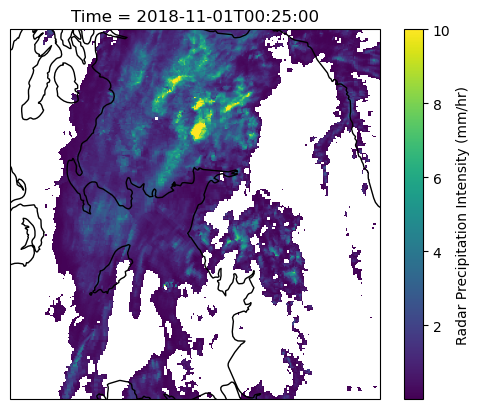

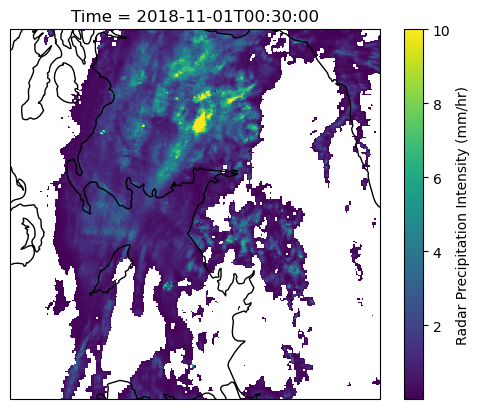

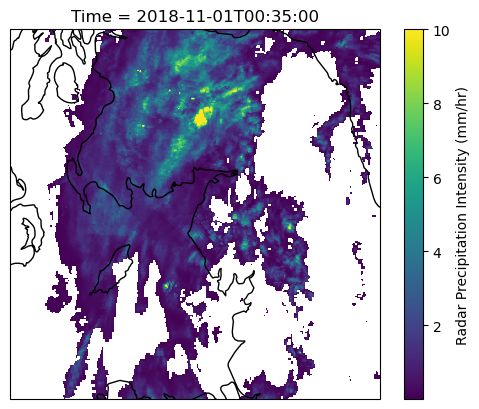

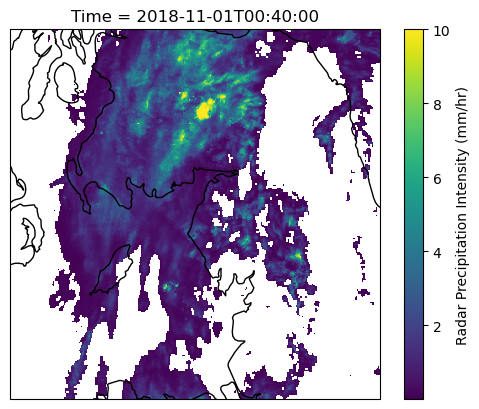

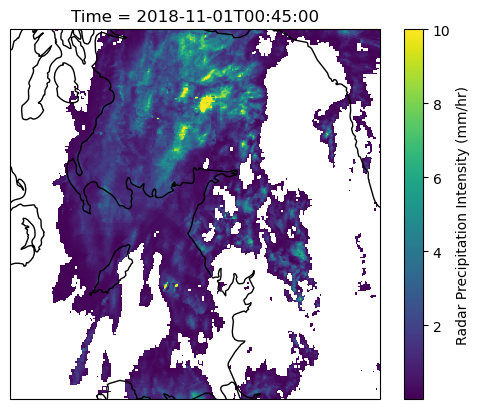

In [17]:
for i in range(0,10,1):
    ax = plt.subplot(111, projection=cart_osgb)
    plt.imshow(np.ma.masked_less(ukmo_dataset['rainrate'][i],0.01),
               origin='lower',
               extent=(ukmo_dataset['x'][0],ukmo_dataset['x'][-1],
                       ukmo_dataset['y'][0],ukmo_dataset['y'][-1]),
               vmin=0.01,vmax=10)
    plt.colorbar(label="Radar Precipitation Intensity (mm/hr)")
    plt.title('Time = {}'.format(ukmo_dataset['Time'][i].values).split('.')[0])
    ax.coastlines(resolution='10m')
    plt.xlim(150000,450000)
    plt.ylim(380000,680000)
    plt.show()

## 3. Extracting timeseries from specified locations

We can use nearest neighbour lookups [(Docs)](https://docs.xarray.dev/en/latest/user-guide/indexing.html#nearest-neighbor-lookups) to extract the closest grid cell values to a specified location. Here we'll define 3 random points and extract time series of precipitation intensity at each location. If we specify the points using latitude and longitude coordinates we can convert those to the reference system of the radar grid (OSGB) before finding the nearest grid centroid to each point.

First we'll print out the full spatial range of the grid files, you can then adjust the random points from the values selected already within that range to see how things change. You could also add additional points spaced around the domain.

In [18]:
print('The radar domain covers latitudes between {:.3f} and {:.3f}'.format(np.nanmin(ukmo_dataset['lat'].values),
                                                                   np.nanmax(ukmo_dataset['lat'].values)))
print('The radar domain covers longitudes between {:.3f} and {:.3f}'.format(np.nanmin(ukmo_dataset['lon'].values),
                                                                   np.nanmax(ukmo_dataset['lon'].values)))

The radar domain covers latitudes between 43.706 and 63.821
The radar domain covers longitudes between -17.962 and 16.117


In [19]:
# Define some random points to look at, using tuple pairs of lat-lon in a list:
points_of_interest = [(54.15,-3.11),
                      (54.6,-3.5),
                      (55.2,-3.8)]


# Vectorise the latitudes and longitudes from the list
points_of_interest_latitudes = [poi[0] for poi in points_of_interest]
points_of_interest_longitudes = [poi[1] for poi in points_of_interest]


# Transform the point coordiantes from latitude and longitude to the grid refernce from the data file (OSGB)
transformer = Transformer.from_crs("EPSG:4326", x.coord_system.as_cartopy_crs())
points_x, points_y = transformer.transform(points_of_interest_latitudes,points_of_interest_longitudes)

Now that we have points and their coordiantes in the native reference system of the grid file we can plot them on a map along with a data field and the coastline as before:

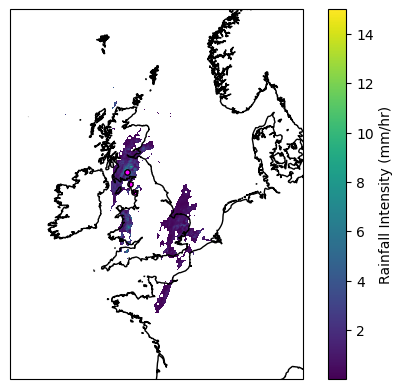

In [20]:
ax = plt.subplot(111, projection=cart_osgb)
plt.imshow(np.ma.masked_less(ukmo_dataset['rainrate'][0],0.01),
           origin='lower',
           extent=(ukmo_dataset['x'][0],ukmo_dataset['x'][-1],
                   ukmo_dataset['y'][0],ukmo_dataset['y'][-1]),
           vmin=0.01,vmax=15)
plt.colorbar(label='Rainfall Intensity (mm/hr)')
ax.coastlines(resolution='10m')
plt.scatter(points_x,points_y,marker='o',c='fuchsia',edgecolors='k',s=15)

To extract time series for these points we can convert their x and y coordiantes into xarray DataArrays with a dimension that account for the number of points we want to extract. When we then cross reference those arrays with our radar dataset we can extract a new 2D array which has the dimensions of "Time" and "POI". This can be especially useful in the future if we want to compare a large number of station locations with data extracted from the radar files.

In [21]:
# Create the DataArrays for x and y of the points:
xpointsDA = xarray.DataArray(points_x, dims=['POI'])
ypointsDA = xarray.DataArray(points_y, dims=['POI'])


# This will select the nearest data from the radar using x and y coordinates of the points
point_dataset = ukmo_dataset.sel(x=xpointsDA, y=ypointsDA, method='nearest')

Looking at the output Dataset we can see that all the atributes and coordinates from the original grid dataset are retained. It's worth remembering that the x and y values are from the grid cell centre which was nearest to the target point (rather than those of the point itself). Once again we can use the built in plotting calls from xarray to get a simple, annotated plot of a data slice (1 point).

In [22]:
point_dataset

<xarray.Dataset> Size: 572B
Dimensions:   (Time: 25, POI: 3)
Coordinates:
  * Time      (Time) datetime64[ns] 200B 2018-11-01 ... 2018-11-01T02:00:00
    y         (POI) float32 12B 4.735e+05 5.235e+05 5.915e+05
    x         (POI) float32 12B 3.275e+05 3.035e+05 2.855e+05
    lon       (POI) float64 24B -3.11 -3.494 -3.799
    lat       (POI) float64 24B 54.15 54.6 55.2
Dimensions without coordinates: POI
Data variables:
    rainrate  (Time, POI) float32 300B 0.8125 0.125 2.719 ... 1.344 1.188 1.906

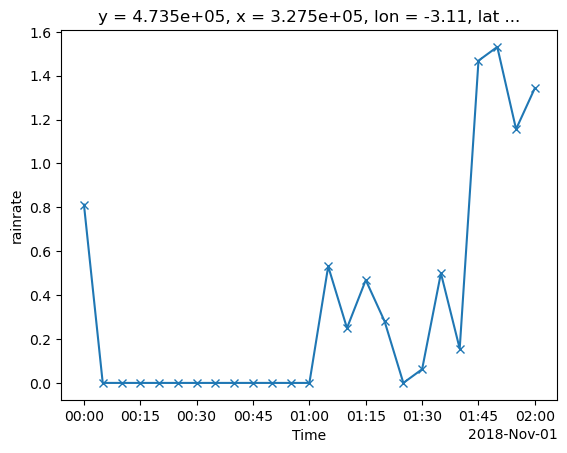

In [23]:
point_dataset['rainrate'][:,0].plot(marker='x')

And we can loop plotting to view all the timeseries simultaneously:

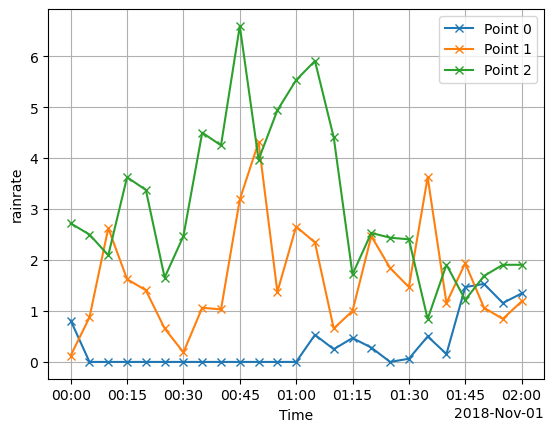

In [24]:
for point_index in range(len(points_of_interest)):
    point_dataset['rainrate'][:,point_index].plot(marker='x',label='Point {}'.format(point_index))
    
plt.legend()
plt.grid()
plt.title('');

This simple notebook has covered how to open and plot Cartesian gridded radar files (from NXPol). The technqiues are equally applicable to other gridded data which can be read into xarray (including UKMO Cartesian radar composites, especially straightforward if the Iris package is also installed). The files from the RAiN-E campaign are 